# 32x32 expGP image reconstruction with GEDA

Image reconstruction.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn

import swyft
from swyft.utils.ns import SwyftSimpleSliceSampler
from swyft.lightning.estimators import LogRatioEstimator_Autoregressive, LogRatioEstimator_Gaussian, LogRatioEstimator_Autoregressive_Gaussian

import pylab as plt

#import pytorch_lightning as pl

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

In [3]:
class GEDA:
    """Gibbs sampler for MVN based on exact data augmentation (GEDA).
    
    The underlying assumption is that the precision matrix can be split as follows:
    
    Q = Q1 + Q2
    Q1 = G1.T L1 G1  (G1 is arbitrary, D1 is diagonal*)
    Q2 = U2.T D2 U2  (U2 is unitary, D2 is diagonal)
    
    omega is a positive hyper-parameter of the algorithm
    it must obey omega < 1/||Q1|| (1/omega should be larger than the largest singular value of Q1)
    
    * In GEDA D1 just has to be positive definite.
    """
    def __init__(self, omega, G1, D1, G1T, U2, D2, U2T):
        """
        Arguments:
            omega: float
            G1: Callable
            D1: Vector
            G1T: Callable
            U2: Callable
            D2: Vector
            U2T: Callable
        """
        self.omega = omega
        self.N = len(D2)
        self.G1 = G1
        self.D1 = D1
        self.G1T = G1T
        self.U2 = U2
        self.D2 = D2
        self.U2T = U2T
        
        self.device = self.D1.device
        
        # Aux definitions
        self.Q1 = lambda x: self.G1T(self.D1*self.G1(x))
        self.R = lambda x: x/self.omega - self.Q1(x)
        
    def _gibbs_sample_step(self, theta, u1):
        mu_u2 = self.G1(u1)
        u2 = mu_u2+torch.randn(self.N).to(self.device)/self.D1**0.5
        mu_u1 = theta - self.omega*(self.Q1(theta)-self.G1T(u2/self.D1))
        u1 = mu_u1 + torch.randn(self.N).to(self.device)*self.omega**0.5
        
        mu_U2_theta = (1/self.omega + self.D2)**-1*self.U2((self.R(u1)+0))
        theta = self.U2T(mu_U2_theta + torch.randn(self.N).to(self.device)/(1/self.omega + self.D2)**0.5)
        
        return theta, u1
    
    def sample(self, N, steps = 100):
        "Generate N samples"
        samples = []
        for i in range(N):
            if i == 0:
                theta = self.U2T(torch.randn(self.N).to(self.device)/(0/self.omega + self.D2)**0.5) # Sample from Q2
                u1 = torch.randn(self.N).to(self.device)*self.omega**0.5  # Sample u1 assuming theta = u2 = 0
            for _ in range(steps):
                theta, u1 = geda._gibbs_sample_step(theta, u1)
            samples.append(theta)
        return samples

In [4]:
N = 1000
K = 100
device = 'cuda'


Sigma = torch.zeros((N, N)).to(device).double()
Sigma[:K,:K] += 0.1
Sigma[K:, K:] += torch.eye(N-K).to(device)*1
Sigma[:K, :K] += torch.eye(K).to(device)*0.001
Q1 = torch.linalg.inv(Sigma)
G1 = torch.linalg.cholesky(Q1).T.float()

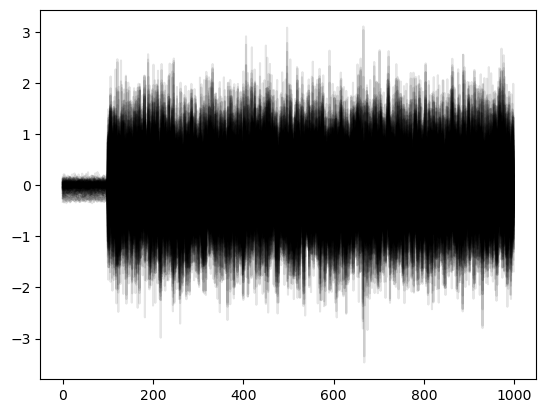

In [5]:
D1 = torch.ones(N).to(device)
D2 = torch.ones(N).to(device)

geda = GEDA(1e-3, lambda x: torch.matmul(G1, x), D1, lambda x: torch.matmul(G1.T, x), lambda x: x, D2, lambda x: x)
samples = geda.sample(100)
for s in samples:
    plt.plot(s.cpu().numpy()[:], alpha = 0.1, color = 'k')